In [1]:

# Do not modify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# inline plotting instead of popping out
%matplotlib inline


df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=',')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [2]:
# Do not modify
df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0


In [3]:
# Do not modify
idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idx].drop('pm2.5', axis=1)
y = df.loc[idx]['pm2.5'].values
X.head()

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir
34320,34321,2013,12,1,0,-13,-2.0,1026.0,0.89,0,0
34321,34322,2013,12,1,1,-14,-3.0,1025.0,3.13,0,0
34322,34323,2013,12,1,2,-13,-3.0,1025.0,0.89,0,0
34323,34324,2013,12,1,3,-13,-4.0,1025.0,0.89,0,0
34324,34325,2013,12,1,4,-13,-3.0,1025.0,1.78,0,0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


In [17]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=50)

sc = StandardScaler()
sc.fit(X)
x_train = sc.transform(x_train)
x_val = sc.transform(x_val)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1491, 11) (1491,)
(639, 11) (639,)


In [18]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20, random_state=50, batch_size=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.batch_size = batch_size

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1]) 
        self.cost_ = []
        for i in range(self.n_iter):
            cost_epoch = []
            for i in range(0, len(X), self.batch_size):
                xi = X[i:i+self.batch_size]
                yi = y[i:i+self.batch_size]
                
                output = self.net_input(xi)

                error = (yi - output)
                cost = 0.5 * error**2
                errors = np.expand_dims(error, axis=-1)
                
                
                self.w_[1:] += self.eta * (xi.T @ errors).squeeze()
                self.w_[0] += self.eta * errors.sum(axis=0)
                cost_epoch.append(cost.sum())
                
            
            avg_cost = sum(cost_epoch) / len(y)
            self.cost_.append(avg_cost)
            
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

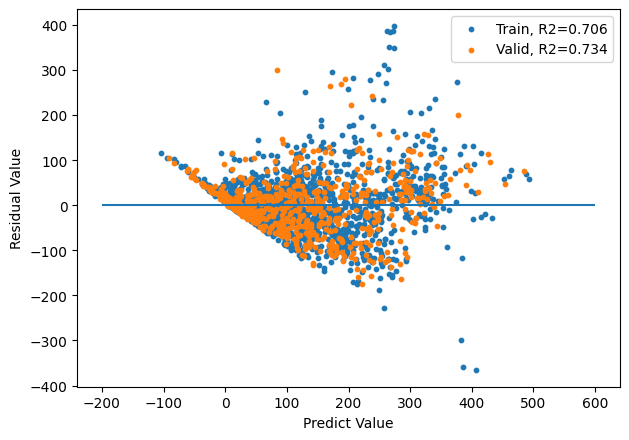

In [19]:
model = PolynomialFeatures(degree=3)
x_total = np.vstack((x_train,x_val))
model.fit(x_total)
x_train_poly = model.transform(x_train)
x_val_poly = model.transform(x_val)

sc = StandardScaler()
x_total_poly = np.vstack((x_train_poly,x_val_poly))
sc.fit(x_total_poly)
x_train_poly = sc.transform(x_train_poly)
x_val_poly = sc.transform(x_val_poly)



model = LinearRegressionGD(eta=1e-5, batch_size=4, n_iter=300)
model.fit(x_train_poly, y_train)
loss = model.cost_


y_train_pred = model.predict(x_train_poly)
y_val_pred = model.predict(x_val_poly)

fig, ax = plt.subplots(dpi=100, figsize=(7, 5))
ax.scatter(y_train_pred, y_train - y_train_pred, s=10, label=f'Train, R2={r2_score(y_train, y_train_pred):.3f}')
ax.scatter(y_val_pred, y_val - y_val_pred, s=10, label=f'Valid, R2={r2_score(y_val, y_val_pred):.3f}')
ax.hlines(y=0, xmin=-200, xmax=600)
ax.legend(frameon=True)
ax.set_xlabel('Predict Value')
ax.set_ylabel('Residual Value')
plt.show()

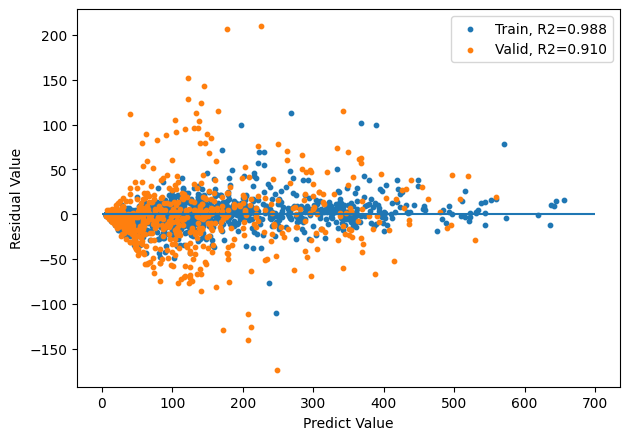

In [20]:
model = RandomForestRegressor(criterion='mse')
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

fig, ax = plt.subplots(dpi=100, figsize=(7, 5))
ax.scatter(y_train_pred, y_train - y_train_pred, s=10, label=f'Train, R2={r2_score(y_train, y_train_pred):.3f}')
ax.scatter(y_val_pred, y_val - y_val_pred, s=10, label=f'Valid, R2={r2_score(y_val, y_val_pred):.3f}')
ax.hlines(y=0, xmin=0, xmax=700)
ax.legend(frameon=True)
ax.set_xlabel('Predict Value')
ax.set_ylabel('Residual Value')
plt.show()